In [1]:
#https://github.com/yousefkotp/Visual-Question-Answering

In [5]:
!pip install Levenshtein -q
!pip install git+https://github.com/openai/CLIP.git -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 17.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 55.4 MB/s eta 0:00:00


In [12]:
# Importing os, numpy and pandas for data manipulation
import os
import numpy as np
import pandas as pd

from tqdm import tqdm
tqdm.pandas()

# For data visualization, we will use matplotlib, wordcloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# For data preprocessing, we will use Counter, train_test_split, Levenshtein distance, Python Image Library and OneHotEncoder
from collections import Counter
import Levenshtein as lev
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# For saving and loading the preprocessed data, we will use pickle
import pickle

# For Building the model, we will use PyTorch and its functions
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import clip
from torch.utils.data import Dataset, DataLoader

# For taking the image from the URL, we will use requests
import requests

# For evaluation, we will need sklearn.metrics.average_precision_score
from sklearn.metrics import average_precision_score

# Importing json for results formatting which will be uploaded for evaluation
import json


In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Check if the directory exists and copy if it does not exist
import os
import shutil

# List of files to copy
files = ["train.json", "train.zip", "valid.json", "valid.zip"]

# Source directory
src_dir = "drive/MyDrive/matsuo-ken-2024-DL/VQA/VQA"

# Destination directory
dest_dir = "./data"

# Ensure the destination directory exists
if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)

# Copy files one by one
for file in files:
    src_file = os.path.join(src_dir, file)
    dest_file = os.path.join(dest_dir, file)

    if not os.path.exists(dest_file):
        shutil.copy(src_file, dest_file)
        print(f"{file} copied.")
    else:
        print(f"{file} already exists, not copying.")


train.json copied.
train.zip copied.
valid.json copied.
valid.zip copied.


In [3]:
# Check if the train.zip file has been unzipped
!if [[ -f "./data/train.zip" && ! -d "./data/train" ]]; then \
  unzip -q ./data/train.zip -d ./data; \
else \
  echo "train.zip already unzipped or not found."; \
fi

# Check if the valid.zip file has been unzipped
!if [[ -f "./data/valid.zip" && ! -d "./data/valid" ]]; then \
  unzip -q ./data/valid.zip -d ./data; \
else \
  echo "valid.zip already unzipped or not found."; \
fi


In [7]:
# Configuring the paths for the dataset
INPUT_PATH = './data'
ANNOTATIONS = INPUT_PATH + ''
TRAIN_PATH = INPUT_PATH + '/train'
VALIDATION_PATH = INPUT_PATH + '/valid'
ANNOTATIONS_TRAIN_PATH = INPUT_PATH + '/train.json'
ANNOTATIONS_VAL_PATH = INPUT_PATH + '/valid.json'
OUTPUT_PATH = '/content/drive/MyDrive/matsuo-ken-2024-DL/VQA/OPENAI_CLIP/'
ANSWER_SPACE = 0 # Will be configured later when we build the vocab using the methodology described in the paper
MODEL_NAME = "ViT-L/14@336px" # This is the backbone of the CLIP model

# Using accelerated computing if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", DEVICE)

Device:  cuda


In [17]:
def read_dataframe(path):
    """
    Reads the JSON file and returns a dataframe with the required columns (image, question, answers)

    Parameters:
        path (str): Path to the JSON file

    Returns:
        df (pandas.DataFrame): Dataframe with the required columns
    """
    df = pd.read_json(path)
    df = df[['image', 'question', 'answers']]
    return df

def split_train_test(dataframe, test_size = 0.05):
    """
    Splits the dataframe into train and test sets

    Parameters:
        dataframe (pandas.DataFrame): Dataframe to be split

    Returns:
        train (pandas.DataFrame): Train set
        test (pandas.DataFrame): Test set
    """
    train, test = train_test_split(dataframe, test_size=test_size, random_state=42)
    return train, test

def plot_histogram(dataframe, column):
    """
    Plots the histogram of the given column

    Parameters:
        dataframe (pandas.DataFrame): Dataframe to be plotted
        column (str): Column to be plotted

    Returns:
        None
    """
    plt.hist(dataframe[column])
    plt.title(column)
    plt.show()

def plot_pie(dataframe, column):
    """
    Plots the pie chart of the given column

    Parameters:
        dataframe (pandas.DataFrame): Dataframe to be plotted
        column (str): Column to be plotted

    Returns:
        None
    """
    value_counts = dataframe[column].value_counts()
    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%')
    plt.title(column)
    plt.show()

def plot_wordcloud(dataframe, column):
    """
    Plots the wordcloud of the given column

    Parameters:
        dataframe (pandas.DataFrame): Dataframe to be plotted
        column (str): Column to be plotted

    Returns:
        None
    """
    text = " ".join([word for word in dataframe[column]])

    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    min_font_size = 10).generate(text)

    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

def explore_dataframe(dataframe):
    """
    Explores the dataframe (EDA) by plotting the pie charts, histograms and wordclouds of the columns

    Parameters:
        dataframe (pandas.DataFrame): Dataframe to be explored

    Returns:
        None
    """
    # plot_pie(dataframe, 'answer_type')
    # plot_pie(dataframe, 'answerable')
    # plot_histogram(dataframe, 'answerable')
    plot_wordcloud(dataframe, 'question')

def get_number_of_distinct_answers(dataframe):
    """
    Returns the number of distinct answers in the dataframe

    Parameters:
        dataframe (pandas.DataFrame): Dataframe to be explored

    Returns:
        len(unique_answers_set) (int): Number of distinct answers in the dataframe
    """
    unique_answers_set = set()
    for row in dataframe['answers']:
        for answer_map in row:
            unique_answers_set.add(answer_map['answer'])
    return len(unique_answers_set)

def process_images(dataframe, image_path, clip_model, preprocessor, device):
    """
    Processes the images in the dataframe and returns the image features

    Parameters:
        dataframe (pandas.DataFrame): Dataframe containing the images
        image_path (str): Path to the input images
        clip_model (clip.model.CLIP): CLIP model
        preprocessor (clip.model.Preprocess): Preprocessor for the CLIP model
        device (torch.device): Device to be used for processing

    Returns:
        images (list): List of image features
    """
    images = []
    for _, row in tqdm(dataframe.iterrows(), total=len(dataframe)):
        full_path = image_path + "/" + row['image']
        image = Image.open(full_path)
        image = preprocessor(image).unsqueeze(0).to(device)
        image_features = clip_model.encode_image(image)
        image_features = torch.flatten(image_features, start_dim=1)
        images.append(image_features)
    return images

def process_questions(dataframe, clip_model,device):
    """
    Processes the questions in the dataframe and returns the question features

    Parameters:
        dataframe (pandas.DataFrame): Dataframe containing the questions
        clip_model (clip.model.CLIP): CLIP model
        device (torch.device): Device to be used for processing

    Returns:
        questions (list): List of question features
    """
    questions = []
    for _, row in tqdm(dataframe.iterrows(), total=len(dataframe)):
        question = row['question']
        question =  clip.tokenize(question).to(device)
        text_features = clip_model.encode_text(question).float()
        text_features = torch.flatten(text_features, start_dim=1)
        questions.append(text_features)
    return questions

In [18]:
train_df = read_dataframe(ANNOTATIONS_TRAIN_PATH)
validation_df = read_dataframe(ANNOTATIONS_TRAIN_PATH)[:500]
train_df, test_df = split_train_test(train_df, test_size=0.05)
ANSWER_SPACE = get_number_of_distinct_answers(train_df) # The answer space will be decreased later when we process the answers
print("Number of distinct answers: ", ANSWER_SPACE)


Number of distinct answers:  38677


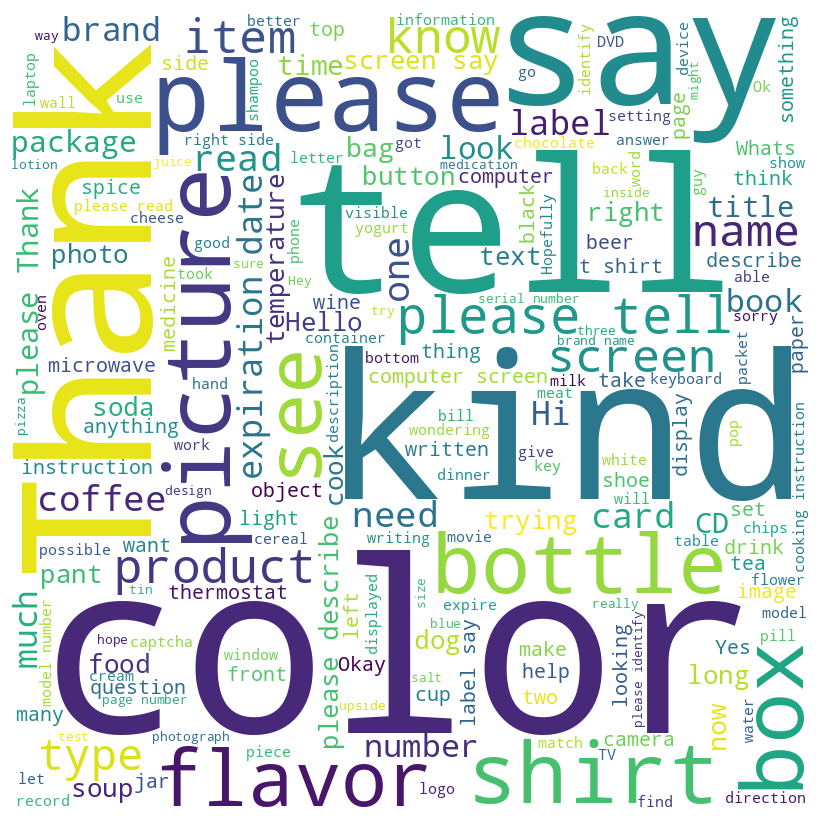

Number of distinct answers:  38677
Number of samples in train:  18879


In [19]:
explore_dataframe(train_df)
print("Number of distinct answers: ", get_number_of_distinct_answers(train_df))
print("Number of samples in train: ", len(train_df))

In [20]:
clip_model, preprocessor = clip.load(MODEL_NAME, device = DEVICE)
clip_model.eval().requires_grad_(False)

training_images = process_images(train_df, TRAIN_PATH, clip_model, preprocessor, DEVICE)
training_questions = process_questions(train_df, clip_model, DEVICE)
with open(OUTPUT_PATH + 'training_images.pkl', 'wb') as f:
    pickle.dump(training_images, f)
with open(OUTPUT_PATH + 'training_questions.pkl', 'wb') as f:
    pickle.dump(training_questions, f)

validation_images = process_images(validation_df, TRAIN_PATH, clip_model, preprocessor, DEVICE)
validation_questions = process_questions(validation_df, clip_model, DEVICE)
with open(OUTPUT_PATH + 'validation_images.pkl', 'wb') as f:
    pickle.dump(validation_images, f)
with open(OUTPUT_PATH + 'validation_questions.pkl', 'wb') as f:
    pickle.dump(validation_questions, f)

test_images = process_images(test_df, TRAIN_PATH, clip_model, preprocessor, DEVICE)
test_questions = process_questions(test_df, clip_model, DEVICE)
with open(OUTPUT_PATH + 'test_images.pkl', 'wb') as f:
    pickle.dump(test_images, f)
with open(OUTPUT_PATH + 'test_questions.pkl', 'wb') as f:
    pickle.dump(test_questions, f)

100%|██████████| 994/994 [00:08<00:00, 120.22it/s]


In [21]:
class VizWizDataset(Dataset):
    def __init__(self, dataframe, answer_onehotencoder = None, model_name = "RN50x64", images_features = torch.tensor([]), questions_features = torch.tensor([])):
        super(VizWizDataset, self).__init__()

        # Total counter for all answers before filtering, used in Tie Breaking when building the answer vocabulary
        self.answer_counter = Counter()

        # Saving image & question embeddings
        self.images_features = images_features
        self.questions_features = questions_features

        # Saving the dataframe
        self.dataframe = dataframe

        # List for answers for each question (each question has 10 answers)
        self.answer_counter_per_question = []

        # Populating the counter for words in answers which will be used when building answer vocabulary
        self.build_answer_counter()

        # Building the answer vocabulary according to the methodology explained in the paper
        self.build_answer_vocab()

        # The number of vocabulary words after filtering
        print("Number of distinct answers: ", len(self.get_answer_vocab()))

        # One hot encoding the answer
        if answer_onehotencoder is None:
            answer_onehotencoder = OneHotEncoder(handle_unknown='ignore')
            answer_onehotencoder.fit(self.copied_dataframe[['answer']])

        # Saving the one hot encoders
        self.answer_onehotencoder = answer_onehotencoder

        # Transforming the answers and answer types to one hot encoded vectors
        self.answer_onehotencoded = answer_onehotencoder.transform(self.copied_dataframe[['answer']]).toarray()

        # Saving the answer categories (vocabulary) which will be used when getting index of the predicted answer
        self.answers_categories = self.answer_onehotencoder.categories_[0].tolist()

        # Saving answers for each question (each question has 10 answers)
        self.build_answer_counter_per_question()

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        answer = torch.tensor(self.answer_onehotencoded[index], dtype=torch.float32)
        answer_counter = torch.tensor(self.answer_counter_per_question[index], dtype=torch.long)
        return self.images_features[index], self.questions_features[index], answer, answer_counter

    def build_answer_counter_per_question(self):
        for index, row in self.dataframe.iterrows():
            temp_list = []
            for answer_map in row['answers']:
                answer = answer_map['answer']
                # check if answer in self.answers_categories
                if answer in self.answers_categories:
                    answer_index = self.answers_categories.index(answer)
                    temp_list.append(answer_index)
            # Torch.tensor requires the all the lists to have constant length, so we pad the list with -1 if needed
            while len(temp_list) < 10:
                temp_list.append(-1)
            self.answer_counter_per_question.append(temp_list)

    def build_answer_vocab(self):
        # Building answer vocab follow this policy:
        # for each question we have 10 answers, we choose the most frequent answer as the answer for this question
        # if there is a tie, we choose the most common one in the whole dataset
        # if there is a tie, we choose the pairwise Levenshtein distance is used to find the answer that is most representative to all others.

        # Copying the original dataframe which will be manipulated
        self.copied_dataframe = self.dataframe.copy()
        self.copied_dataframe.drop(columns=['answers'], inplace=True)

        # Adding extra column named 'answer'
        self.copied_dataframe['answer'] = None

        for index, row in self.dataframe.iterrows():
            intermediate_counter = Counter()
            for answer_map in row['answers']:
                answer = answer_map['answer']
                intermediate_counter.update([answer])

            # let's see the top elements in the answers_counter to check if there is a tie
            top_elements = intermediate_counter.most_common(1)
            if len(top_elements) == 1:
                self.copied_dataframe.at[index, 'answer'] = top_elements[0][0]
            else:
                # let's see who is the most common answer in the whole dataset
                top_elements = self.answer_counter.most_common(1)
                if len(top_elements) == 1:
                    self.copied_dataframe.at[index, 'answer'] = top_elements[0][0]
                else:
                    # let's get the minimum levenshtein distance between the answers in top_elements
                    current_min = np.inf
                    current_answer = None
                    for answer in top_elements:
                        total_distance = 0
                        for answer2 in top_elements:
                            if answer != answer2:
                                lev_distance = lev.distance(answer[0], answer2[0])
                                total_distance += lev_distance
                        if total_distance < current_min:
                            current_min = total_distance
                            current_answer = answer[0]
                    self.copied_dataframe.at[index, 'answer'] = current_answer
        return

    def build_answer_counter(self):
        for row in self.dataframe['answers']:
            for answer_map in row:
                self.answer_counter.update([answer_map['answer']])

    def get_answer_vocab(self):
        return self.copied_dataframe['answer'].unique()


In [27]:
class VQAModel(nn.Module):

    def __init__(self, num_classes, hidden_size, model_name = "ViT-L/14@336px", device = torch.device("cpu")):
        super(VQAModel, self).__init__()

        self.training_losses = []
        self.validation_losses = []

        self.training_accuracies = []
        self.validation_accuracies = []

        self.vizwiz_training_accuracies = []
        self.vizwiz_validation_accuracies = []

        self.device = device
        self.model_name = model_name

        # Loading the CLIP model
        self.clip_model, self.preprocess = clip.load(model_name, device = device)

        # Freezing the CLIP model
        for param in self.clip_model.parameters():
            param.requires_grad = False

        # First linear layer
        self.linear_layer1 = nn.Sequential(
            nn.LayerNorm(self.clip_model.visual.output_dim + self.clip_model.text_projection.shape[1]),
            nn.Dropout(p=0.5),
            nn.Linear(self.clip_model.visual.output_dim + self.clip_model.text_projection.shape[1], hidden_size)
        )

        # Second linear layer
        self.linear_layer2 = nn.Sequential(
            nn.LayerNorm(hidden_size),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_size, num_classes)
        )

        self.answer_mask_layer = nn.Linear(4, num_classes)

        self.sigmoid = nn.Sigmoid()

    def forward(self, image, question):

        # Flattening and concatenating the image and question features
        image = torch.flatten(image, start_dim=1)
        question = torch.flatten(question, start_dim=1)
        features = torch.cat((image, question), dim=1)

        # Passing the features through the first linear layer
        features = self.linear_layer1(features)

        # Passing the features through the second linear layer
        output = self.linear_layer2(features)

        return output

    def train_model(self, training_dataloader, validation_dataloader, test_dataloader, criterion, optimizer, epochs = 10, save_path = None, save_every = 1):
        for epoch in range(1,epochs+1):
            training_loss, training_accuracy, training_vizwiz_accuracy = self.training_step(training_dataloader, criterion, optimizer, self.device)
            validation_loss, validation_accuracy, validation_vizwiz_accuracy = self.validation_step(validation_dataloader, criterion, self.device)
            test_accuracy, test_vizwiz_accuracy = self.test_step(test_dataloader)

            self.training_losses.append(training_loss)
            self.validation_losses.append(validation_loss)

            self.training_accuracies.append(training_accuracy)
            self.validation_accuracies.append(validation_accuracy)

            self.vizwiz_training_accuracies.append(training_vizwiz_accuracy)
            self.vizwiz_validation_accuracies.append(validation_vizwiz_accuracy)


            print("Epoch: {} | Training Loss: {:.3f} | Validation Loss: {:.3f}".format(epoch, training_loss, validation_loss))
            print("Epoch: {} | Training Accuracy: {:.3f} | Validation Accuracy: {:.3f} | Test Accuracy: {:.3f}".format(epoch, training_accuracy, validation_accuracy, test_accuracy))
            print("Epoch: {} | Training VizWiz Accuracy: {:.3f} | Validation VizWiz Accuracy: {:.3f} | Test VizWiz Accuracy: {:.3f}".format(epoch, training_vizwiz_accuracy, validation_vizwiz_accuracy, test_vizwiz_accuracy))

            if save_path != None and epoch % save_every == 0:
                self.save_model(save_path + "epoch_{}.pth".format(epoch))
        return

    def training_step(self, dataloader, criterion, optimizer, device):
        training_loss, training_accuracy, vizwiz_accuracy, total_sum = 0.0, 0.0, 0.0, 0
        self.train()
        for _, batch in enumerate(dataloader):
            image, question, answer, answers_for_questions = batch
            image, question, answer, answers_for_questions = image.to(device), question.to(device), answer.to(device), answers_for_questions.to(device)
            optimizer.zero_grad()
            output = self.forward(image, question)
            loss = criterion(output, answer)
            loss.backward()
            optimizer.step()
            training_loss += loss.item()
            predicted_answer = torch.argmax(output, dim = 1)
            actual_answer = torch.argmax(answer, dim = 1)
            for i in range(len(answer)):
                if actual_answer[i] == predicted_answer[i]:
                    training_accuracy +=1
                total_sum +=1
                vizwiz_accuracy += min(1, torch.sum(torch.eq(predicted_answer[i], answers_for_questions[i])).item()/3)


        training_loss /= len(dataloader)
        training_accuracy /= total_sum
        vizwiz_accuracy /= total_sum

        return training_loss, training_accuracy, vizwiz_accuracy


    def validation_step(self, dataloader, criterion, device):
        validation_loss, validation_accuracy, vizwiz_accuracy, total_sum = 0.0, 0.0, 0.0, 0
        self.eval()
        with torch.no_grad():
            for _, batch in enumerate(dataloader):
                image, question, answer, answers_for_questions = batch
                image, question, answer, answers_for_questions = image.to(device), question.to(device), answer.to(device), answers_for_questions.to(device)
                output = self.forward(image, question)

                loss = criterion(output, answer)
                validation_loss += loss.item()
                predicted_answer = torch.argmax(output, dim = 1)
                actual_answer = torch.argmax(answer, dim = 1)
                for i in range(len(answer)):
                    if torch.sum(answer[i]) == 0:
                        continue
                    if actual_answer[i] == predicted_answer[i]:
                        validation_accuracy += 1
                    total_sum +=1
                    vizwiz_accuracy += min(1, torch.sum(torch.eq(predicted_answer[i], answers_for_questions[i])).item()/3)

        validation_loss /= len(dataloader)
        validation_accuracy /= total_sum
        vizwiz_accuracy /= total_sum

        return validation_loss, validation_accuracy, vizwiz_accuracy

    def test_step(self, dataloader):
        self.eval()
        accuracy, total_sum, vizwiz_accuracy = 0.0, 0, 0.0

        with torch.no_grad():
            for _, batch in enumerate(dataloader):
                image, question, answer, answers_for_questions = batch
                image, question, answer, answers_for_questions = image.to(self.device), question.to(self.device), answer.to(self.device), answers_for_questions.to(self.device)
                output = self.forward(image, question)

                predicted_answer = torch.argmax(output, dim = 1)
                actual_answer = torch.argmax(answer, dim = 1)
                for i in range(len(answer)):
                    if torch.sum(answer[i]) == 0:
                        continue
                    if predicted_answer[i] == actual_answer[i]:
                        accuracy += 1
                    vizwiz_accuracy += min(1, torch.sum(torch.eq(predicted_answer[i], answers_for_questions[i])).item()/3)
                    total_sum +=1


        accuracy /= total_sum
        vizwiz_accuracy /= total_sum
        return accuracy, vizwiz_accuracy

    def save_model(self, path):
        """
        Saves the model state dictionary to the given path.

        Args:
        - self: the model object
        - path (str): the path to save the model state dictionary

        Returns:
        - None
        """
        torch.save(self.state_dict(), path)

    def load_model(self, path):
        """
        Loads the model state dictionary from the given path.

        Args:
        - self: the model object
        - path (str): the path to load the model state dictionary

        Returns:
        - self: the loaded model object
        """
        self.load_state_dict(torch.load(path))
        self.eval()
        return self

    def predict(self, image, question):
        """
        Predicts the output and answer type for the given image and question.

        Args:
        - self: the model object
        - image (tensor): the image tensor
        - question (tensor): the question tensor

        Returns:
        - output (tensor): the predicted output tensor
        """
        output = self.forward(image, question)
        return output

    def plot_loss(self):
        """
        Plots the training and validation losses.

        Args:
        - self: the model object

        Returns:
        - None
        """
        plt.plot(self.training_losses, label = "Training Loss")
        plt.plot(self.validation_losses, label = "Validation Loss")
        plt.legend()
        plt.show()

    def plot_accuracy(self):
        """
        Plots the training and validation accuracies.

        Args:
        - self: the model object

        Returns:
        - None
        """
        plt.plot(self.training_accuracies, label = "Training Accuracy")
        plt.plot(self.validation_accuracies, label = "Validation Accuracy")
        plt.legend()
        plt.show()

    def plot_vizwiz_accuracy(self):
        """
        Plots the VizWiz training and validation accuracies.

        Args:
        - self: the model object

        Returns:
        - None
        """
        plt.plot(self.vizwiz_training_accuracies, label = "VizWiz Training Accuracy")
        plt.plot(self.vizwiz_validation_accuracies, label = "VizWiz Validation Accuracy")
        plt.legend()
        plt.show()

    def test_model(self, image_path, question):
        """
        Tests the model by predicting the answer and answer type for the given image and question.

        Args:
        - self: the model object
        - image_path (str): the path to the image file or URL
        - question (str): the question to be asked

        Returns:
        - predicted_answer (tensor): the predicted answer tensor
        """
        self.eval()
        if image_path.startswith("http"):
            image = Image.open(requests.get(image_path, stream = True).raw)
        else:
            image = Image.open(image_path)

        image = self.preprocess(image).unsqueeze(0).to(self.device)
        image_features = self.clip_model.encode_image(image)
        image_features = torch.flatten(image_features, start_dim=1)

        question =  clip.tokenize(question).to(self.device)
        text_features = self.clip_model.encode_text(question).float()
        text_features = torch.flatten(text_features, start_dim=1)

        predicted_answer = self.predict(image_features, text_features)
        return predicted_answer

    def print_CLIP_model(self):
        """
        Prints the details of the selected CLIP model.

        Args:
        - self: the model object

        Returns:
        - None
        """
        input_resolution = self.clip_model.visual.input_resolution
        context_length = self.clip_model.context_length
        vocab_size = self.clip_model.vocab_size

        print("Selected model:", self.model_name)
        print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in self.clip_model.parameters()]):,}")
        print("Input resolution:", input_resolution)
        print("Context length:", context_length)
        print("Vocab size:", vocab_size)
        print("")


In [23]:
with open(OUTPUT_PATH + 'training_images.pkl', 'rb') as f:
    training_images = pickle.load(f)
with open(OUTPUT_PATH + 'training_questions.pkl', 'rb') as f:
    training_questions = pickle.load(f)

with open(OUTPUT_PATH + 'validation_images.pkl', 'rb') as f:
    validation_images = pickle.load(f)
with open(OUTPUT_PATH + 'validation_questions.pkl', 'rb') as f:
    validation_questions = pickle.load(f)

with open(OUTPUT_PATH + 'test_images.pkl', 'rb') as f:
    test_images = pickle.load(f)
with open(OUTPUT_PATH + 'test_questions.pkl', 'rb') as f:
    test_questions = pickle.load(f)

In [25]:
# Constructing the training dataset
training_dataset = VizWizDataset(train_df, None, MODEL_NAME, training_images, training_questions)
ANSWER_ONEHOTENCODER = training_dataset.answer_onehotencoder

# Saving the fitted one hot encoders
with open(OUTPUT_PATH + 'answer_onehotencoder.pkl', 'wb') as f:
    pickle.dump(ANSWER_ONEHOTENCODER, f)

# Constructing the validation dataset
validation_dataset = VizWizDataset(validation_df, ANSWER_ONEHOTENCODER, MODEL_NAME, validation_images, validation_questions)

# Constructing the test dataset
test_dataset = VizWizDataset(test_df, ANSWER_ONEHOTENCODER, MODEL_NAME, test_images, test_questions)

# Configuring the data loaders
BATCH_SIZE = 32 # 64 is good too but 32 is better (variance wise)

# Constructing the training, validation and test data loaders
training_dataloader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

Number of distinct answers:  5099
Number of distinct answers:  254
Number of distinct answers:  437


Selected model: ViT-L/14@336px
Model parameters: 427,944,193
Input resolution: 336
Context length: 77
Vocab size: 49408

Epoch: 1 | Training Loss: 5.307 | Validation Loss: 4.489
Epoch: 1 | Training Accuracy: 0.381 | Validation Accuracy: 0.400 | Test Accuracy: 0.530
Epoch: 1 | Training VizWiz Accuracy: 0.479 | Validation VizWiz Accuracy: 0.487 | Test VizWiz Accuracy: 0.621
Epoch: 2 | Training Loss: 4.820 | Validation Loss: 3.881
Epoch: 2 | Training Accuracy: 0.399 | Validation Accuracy: 0.453 | Test Accuracy: 0.557
Epoch: 2 | Training VizWiz Accuracy: 0.493 | Validation VizWiz Accuracy: 0.545 | Test VizWiz Accuracy: 0.651
Epoch: 3 | Training Loss: 4.285 | Validation Loss: 3.214
Epoch: 3 | Training Accuracy: 0.420 | Validation Accuracy: 0.503 | Test Accuracy: 0.575
Epoch: 3 | Training VizWiz Accuracy: 0.513 | Validation VizWiz Accuracy: 0.593 | Test VizWiz Accuracy: 0.665
Epoch: 4 | Training Loss: 3.675 | Validation Loss: 2.409
Epoch: 4 | Training Accuracy: 0.451 | Validation Accuracy: 0

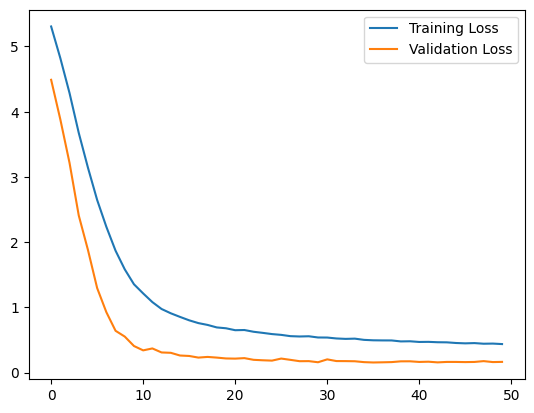

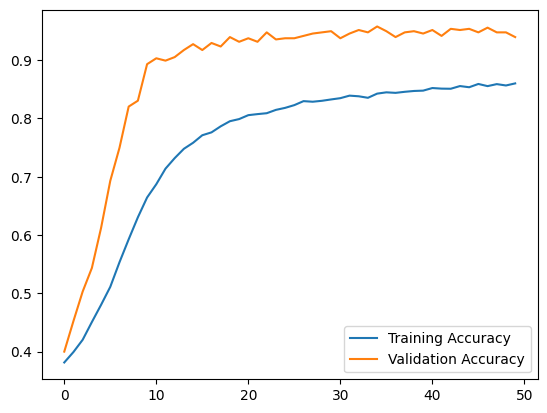

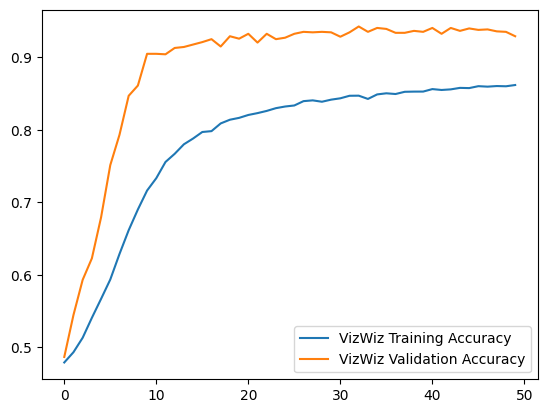

In [28]:
# Configuring training's hyperparameters
NUM_EPOCHS = 50
LR = 5e-4
WEIGHT_DECAY = 0
NUM_CLASSES = len(training_dataset.get_answer_vocab())
SAVE_PATH = OUTPUT_PATH
SAVE_EVERY = 5

# Initializing the model
model = VQAModel(num_classes=NUM_CLASSES, device= DEVICE, hidden_size=512, model_name=MODEL_NAME).to(DEVICE)
model.print_CLIP_model()

# Initializing the loss function and optimizer
loss_function = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay = WEIGHT_DECAY)

# Training the model and plotting the loss and accuracy
model.train_model(training_dataloader, validation_dataloader, test_dataloader, loss_function, optimizer, epochs=NUM_EPOCHS, save_path=SAVE_PATH, save_every=SAVE_EVERY)
model.plot_loss()
model.plot_accuracy()
model.plot_vizwiz_accuracy()

In [31]:
df = pd.read_json("./data/valid.json")
df = df[['image', 'question']]

# let's create two json objects to store the output of the model then write them to a file
model_answers = []

for i in tqdm(range(len(df))):
    image_url = df['image'][i]
    question = df['question'][i]
    image_path = VALIDATION_PATH + "/" + image_url
    predicted_answer = model.test_model(image_path = image_path, question = question)
    answer = ANSWER_ONEHOTENCODER.inverse_transform(predicted_answer.cpu().detach().numpy())
    answer_result = {'image': image_url, 'answer': answer[0][0]}
    model_answers.append(answer_result)


100%|██████████| 4969/4969 [05:06<00:00, 16.22it/s]


In [33]:
submission = np.array([ans['answer'] for ans in model_answers])
np.save("submission.npy", submission)

# save to drive
DATA_PATH = '/content/drive/MyDrive/matsuo-ken-2024-DL/VQA/'
# add timestamp to name
import time
time_stamp = time.strftime("%Y%m%d-%H%M%S")
torch.save(model.state_dict(), DATA_PATH + 'model_' + time_stamp + '_.pth')
np.save(DATA_PATH + 'submission_' + time_stamp, submission)